In [ ]:
#This can be ignored, i just had a hard time getting cuDNN and CUDA working locally
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA available: True
GPU count: 1
Current GPU: NVIDIA GeForce RTX 3070


In [ ]:
!pip install optuna
!pip install matplotlib
!pip install numpy scikit-learn
!pip install tqdm


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import optuna
import numpy as np
from tqdm import tqdm


In [ ]:
#this is the main way that we are augmenting through random adjustments to the image
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Chosing categorial cross-entropy due to MNIST dataset being catagorial with 10 possible classes.

For a single data point with true class $y$ (one-hot encoded as $\left.\left[y_1, y_2, \ldots, y_C\right]\right)$ and predicted probabilities $\hat{y}=$ $\left[\hat{y}_1, \hat{y_2}, \ldots, \hat{y_C}\right]$ over $C$ classes, the categorical cross-entropy is given by:

$$
\text { Loss }=-\sum_{i=1}^C y_i \cdot \log \left(\hat{y_i}\right)
$$

In [ ]:
#simple baseline model
# we want local features, so first we have kernel size 3 for spatial hierachies in images
# we start with 32 filters to capture features, padding to have spatial dims
#buils on initial feature maps with 32 inputs frmo conv1
#downsamples 2x2 kernal
#fc layers to reduce dims and then output to 10, with softmax for probability dist
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

model = BaselineModel()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if torch.cuda.is_available():
    print("using gpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#helpers
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy


using gpu


In [ ]:
num_epochs = 10
train_loss_history_baseline = []
val_loss_history_baseline = []
train_acc_history_baseline = []
val_acc_history_baseline = []

#this can largely be ignroed, debugging for cuda local, uses cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    if device.type == 'cuda':
        #double checking memory usage
        print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_loss_history_baseline.append(train_loss)
    val_loss_history_baseline.append(val_loss)
    train_acc_history_baseline.append(train_acc)
    val_acc_history_baseline.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.2f}%")

device: cuda
Epoch [1/10]
Allocated GPU memory: 0.84 MB


Train Loss: 1.6737, Train Acc: 79.72% | Val Loss: 1.5270, Val Acc: 94.12%
Epoch [2/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.5087, Train Acc: 95.64% | Val Loss: 1.5032, Val Acc: 95.99%
Epoch [3/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4979, Train Acc: 96.53% | Val Loss: 1.4976, Val Acc: 96.53%
Epoch [4/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4915, Train Acc: 97.10% | Val Loss: 1.4928, Val Acc: 96.95%
Epoch [5/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4880, Train Acc: 97.44% | Val Loss: 1.4922, Val Acc: 96.95%
Epoch [6/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4852, Train Acc: 97.69% | Val Loss: 1.4844, Val Acc: 97.78%
Epoch [7/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4832, Train Acc: 97.92% | Val Loss: 1.4822, Val Acc: 97.99%
Epoch [8/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4823, Train Acc: 97.97% | Val Loss: 1.4828, Val Acc: 97.93%
Epoch [9/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4806, Train Acc: 98.12% | Val Loss: 1.4798, Val Acc: 98.11%
Epoch [10/10]
Allocated GPU memory: 19.62 MB


Train Loss: 1.4798, Train Acc: 98.21% | Val Loss: 1.4781, Val Acc: 98.33%
Test Accuracy: 99.01%


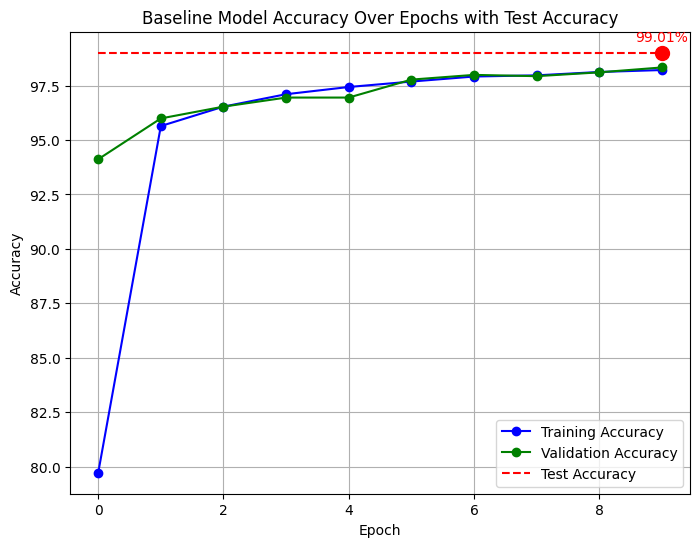

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_history_baseline, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc_history_baseline, label='Validation Accuracy', color='green', marker='o')
plt.hlines(test_acc, xmin=0, xmax=num_epochs - 1, colors='red', linestyles='dashed', label='Test Accuracy')
plt.scatter(num_epochs - 1, test_acc, color='red', s=100)
plt.text(num_epochs - 1, test_acc + 0.5, f"{test_acc:.2f}%", color='red', ha='center')
plt.title('Baseline Model Accuracy Over Epochs with Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
#here i wanted to test a  model that was a bit deeper, so we know what kind of model complexity would result in dimishing returns
#this can help us inform our optuna hyperparameters to show if the deeper model might need stronger regularization (higher dropout or L2 factors)
#first we extract basic features with 2 conv
#then we pool and have our first dropout to prevent overfitting
#this is then repeated without pooling
#finally this connects in our fc layers, with a dropout between in order to prevent overfitting before final classification layer
class DeeperModel(nn.Module):
    def __init__(self):
        super(DeeperModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)

        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x


deeper_model = DeeperModel().to(device)
optimizer = optim.Adam(deeper_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



In [ ]:
num_epochs = 10
train_loss_history_deeper = []
val_loss_history_deeper = []
train_acc_history_deeper = []
val_acc_history_deeper = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    if device.type == 'cuda':
        print(f"GPU memory: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    train_loss, train_acc = train(deeper_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(deeper_model, val_loader, criterion)

    train_loss_history_deeper.append(train_loss)
    val_loss_history_deeper.append(val_loss)
    train_acc_history_deeper.append(train_acc)
    val_acc_history_deeper.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

test_loss, test_acc = evaluate(deeper_model, test_loader, criterion)
print(f"Deeper Model Test Accuracy: {test_acc:.2f}%")


Epoch [1/10]
GPU memory: 21.94 MB


Train Loss: 1.7482, Train Acc: 71.22% | Val Loss: 1.5993, Val Acc: 86.17%
Epoch [2/10]
GPU memory: 31.91 MB


Train Loss: 1.6122, Train Acc: 84.85% | Val Loss: 1.5899, Val Acc: 87.11%
Epoch [3/10]
GPU memory: 31.91 MB


Train Loss: 1.5407, Train Acc: 92.04% | Val Loss: 1.4951, Val Acc: 96.64%
Epoch [4/10]
GPU memory: 31.91 MB


Train Loss: 1.5122, Train Acc: 94.93% | Val Loss: 1.4892, Val Acc: 97.15%
Epoch [5/10]
GPU memory: 31.91 MB


Train Loss: 1.5053, Train Acc: 95.60% | Val Loss: 1.4938, Val Acc: 96.78%
Epoch [6/10]
GPU memory: 31.91 MB


Train Loss: 1.5059, Train Acc: 95.50% | Val Loss: 1.4863, Val Acc: 97.49%
Epoch [7/10]
GPU memory: 31.91 MB


Train Loss: 1.5020, Train Acc: 95.88% | Val Loss: 1.4871, Val Acc: 97.40%
Epoch [8/10]
GPU memory: 31.91 MB


Train Loss: 1.5020, Train Acc: 95.89% | Val Loss: 1.4865, Val Acc: 97.47%
Epoch [9/10]
GPU memory: 31.91 MB


Train Loss: 1.4986, Train Acc: 96.26% | Val Loss: 1.4857, Val Acc: 97.54%
Epoch [10/10]
GPU memory: 31.91 MB


Train Loss: 1.4986, Train Acc: 96.24% | Val Loss: 1.4855, Val Acc: 97.55%
Deeper Model Test Accuracy: 98.53%


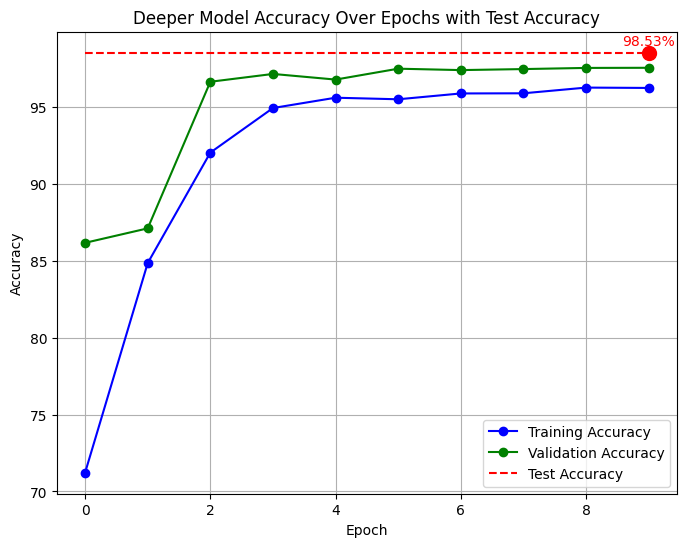

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_acc_history_deeper, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc_history_deeper, label='Validation Accuracy', color='green', marker='o')
plt.hlines(test_acc, xmin=0, xmax=num_epochs - 1, colors='red', linestyles='dashed', label='Test Accuracy')
plt.scatter(num_epochs - 1, test_acc, color='red', s=100)
plt.text(num_epochs - 1, test_acc + 0.5, f"{test_acc:.2f}%", color='red', ha='center')

plt.title('Deeper Model Accuracy Over Epochs with Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
#in this model batchnorm is integrated to use higher learning rate, for faster convergence, and is able to reduce the need for dropout/l2
#since it has inherent regularization
#this is reflexted int he folowing architecture
#conv->bn so we extract feature, then normalizes the conv layers to stabilze
class BNModel(nn.Module):
    def __init__(self):
        super(BNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)

        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout3(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

bn_model = BNModel().to(device)
optimizer = optim.Adam(bn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
num_epochs = 10
train_loss_history_bn = []
val_loss_history_bn = []
train_acc_history_bn = []
val_acc_history_bn = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    if device.type == 'cuda':
        print(f"GPU memory: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    train_loss, train_acc = train(bn_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(bn_model, val_loader, criterion)

    train_loss_history_bn.append(train_loss)
    val_loss_history_bn.append(val_loss)
    train_acc_history_bn.append(train_acc)
    val_acc_history_bn.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Test accuracy
test_loss, test_acc = evaluate(bn_model, test_loader, criterion)
print(f"BN Model Test Accuracy: {test_acc:.2f}%")


Epoch [1/10]
GPU memory: 28.60 MB


Train Loss: 1.5413, Train Acc: 94.55% | Val Loss: 1.4858, Val Acc: 98.08%
Epoch [2/10]
GPU memory: 38.59 MB


Train Loss: 1.4883, Train Acc: 97.81% | Val Loss: 1.4792, Val Acc: 98.53%
Epoch [3/10]
GPU memory: 38.59 MB


Train Loss: 1.4837, Train Acc: 98.06% | Val Loss: 1.4761, Val Acc: 98.65%
Epoch [4/10]
GPU memory: 38.59 MB


Train Loss: 1.4812, Train Acc: 98.26% | Val Loss: 1.4784, Val Acc: 98.42%
Epoch [5/10]
GPU memory: 38.59 MB


Train Loss: 1.4792, Train Acc: 98.39% | Val Loss: 1.4743, Val Acc: 98.84%
Epoch [6/10]
GPU memory: 38.59 MB


Train Loss: 1.4783, Train Acc: 98.46% | Val Loss: 1.4756, Val Acc: 98.65%
Epoch [7/10]
GPU memory: 38.59 MB


Train Loss: 1.4766, Train Acc: 98.61% | Val Loss: 1.4726, Val Acc: 98.96%
Epoch [8/10]
GPU memory: 38.59 MB


Train Loss: 1.4770, Train Acc: 98.55% | Val Loss: 1.4716, Val Acc: 99.05%
Epoch [9/10]
GPU memory: 38.59 MB


Train Loss: 1.4760, Train Acc: 98.64% | Val Loss: 1.4709, Val Acc: 99.08%
Epoch [10/10]
GPU memory: 38.59 MB


Train Loss: 1.4743, Train Acc: 98.82% | Val Loss: 1.4712, Val Acc: 99.05%
BN Model Test Accuracy: 99.42%


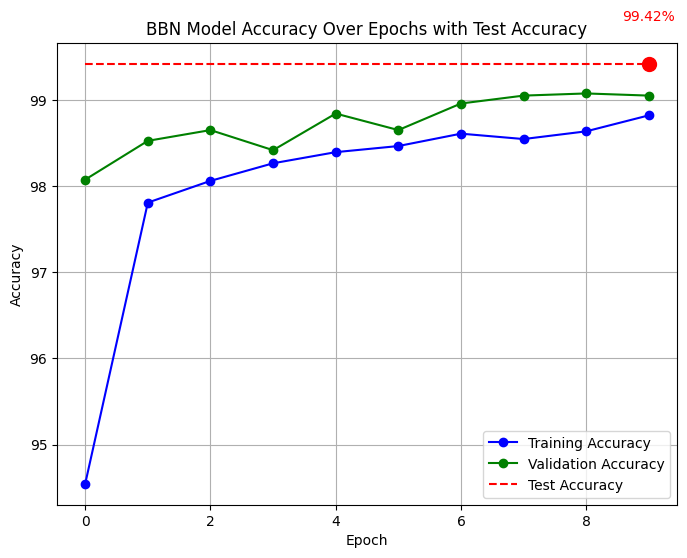

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_acc_history_bn, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc_history_bn, label='Validation Accuracy', color='green', marker='o')
plt.hlines(test_acc, xmin=0, xmax=num_epochs - 1, colors='red', linestyles='dashed', label='Test Accuracy')
plt.scatter(num_epochs - 1, test_acc, color='red', s=100)
plt.text(num_epochs - 1, test_acc + 0.5, f"{test_acc:.2f}%", color='red', ha='center')

plt.title('BBN Model Accuracy Over Epochs with Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
#in this model the idea was to have feature extraction similar to baseline and deeper model, but instead the network
#now penalizes large weigths in the mode to prevent overfitting, using the optimizers weight_decay
class L2Model(nn.Module):
    def __init__(self):
        super(L2Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)

        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

l2_model = L2Model().to(device)
weight_decay = 1e-4
optimizer = optim.Adam(l2_model.parameters(), lr=0.001, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


In [ ]:
num_epochs = 10
train_loss_history_l2 = []
val_loss_history_l2 = []
train_acc_history_l2 = []
val_acc_history_l2 = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    if device.type == 'cuda':
        print(f"GPU memory: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    train_loss, train_acc = train(l2_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(l2_model, val_loader, criterion)

    train_loss_history_l2.append(train_loss)
    val_loss_history_l2.append(val_loss)
    train_acc_history_l2.append(train_acc)
    val_acc_history_l2.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

test_loss, test_acc = evaluate(l2_model, test_loader, criterion)
print(f"L2 Model Test Accuracy: {test_acc:.2f}%")


Epoch [1/10]
GPU memory: 35.26 MB


Train Loss: 1.7264, Train Acc: 73.47% | Val Loss: 1.5166, Val Acc: 94.58%
Epoch [2/10]
GPU memory: 45.23 MB


Train Loss: 1.5263, Train Acc: 93.56% | Val Loss: 1.4952, Val Acc: 96.56%
Epoch [3/10]
GPU memory: 45.23 MB


Train Loss: 1.5147, Train Acc: 94.70% | Val Loss: 1.5013, Val Acc: 95.94%
Epoch [4/10]
GPU memory: 45.23 MB


Train Loss: 1.5066, Train Acc: 95.48% | Val Loss: 1.4927, Val Acc: 96.78%
Epoch [5/10]
GPU memory: 45.23 MB


Train Loss: 1.5026, Train Acc: 95.86% | Val Loss: 1.4846, Val Acc: 97.65%
Epoch [6/10]
GPU memory: 45.23 MB


Train Loss: 1.4992, Train Acc: 96.20% | Val Loss: 1.4826, Val Acc: 97.83%
Epoch [7/10]
GPU memory: 45.23 MB


Train Loss: 1.4967, Train Acc: 96.47% | Val Loss: 1.4859, Val Acc: 97.48%
Epoch [8/10]
GPU memory: 45.23 MB


Train Loss: 1.4970, Train Acc: 96.44% | Val Loss: 1.4846, Val Acc: 97.61%
Epoch [9/10]
GPU memory: 45.23 MB


Train Loss: 1.4945, Train Acc: 96.66% | Val Loss: 1.4853, Val Acc: 97.51%
Epoch [10/10]
GPU memory: 45.23 MB


Train Loss: 1.4922, Train Acc: 96.94% | Val Loss: 1.4819, Val Acc: 97.90%
L2 Model Test Accuracy: 98.97%


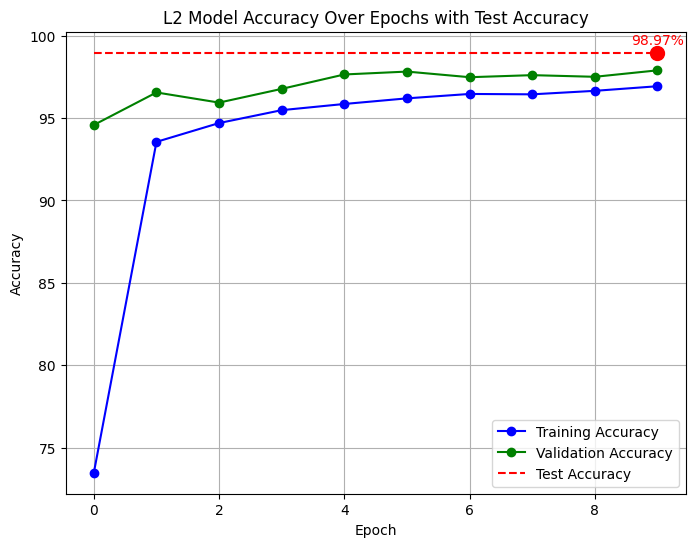

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_acc_history_l2, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc_history_l2, label='Validation Accuracy', color='green', marker='o')
plt.hlines(test_acc, xmin=0, xmax=num_epochs - 1, colors='red', linestyles='dashed', label='Test Accuracy')
plt.scatter(num_epochs - 1, test_acc, color='red', s=100)
plt.text(num_epochs - 1, test_acc + 0.5, f"{test_acc:.2f}%", color='red', ha='center')

plt.title('L2 Model Accuracy Over Epochs with Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
num_classes = 10
#this was largely inspired as a result of choosing a mix of the models previous, and trying to select what worked architecturally as well as some
#motivation in the batch norm paper where it was applied in the mnist data set
class CNNModel(nn.Module):
    def __init__(self, num_filters, kernel_size, dropout_rate, dense_units, l2_reg, num_classes):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(num_filters, num_filters, kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate),

            nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters*2),
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters*2),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate)
        )

        self.flatten_size = (num_filters*2) * (28//4) * (28//4)

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, dense_units),
            nn.ReLU(),
            nn.BatchNorm1d(dense_units),
            nn.Dropout(dropout_rate),
            nn.Linear(dense_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#maybe there is a more optimal way to build this, but the previous models gave a decent idea for how the different parameters could be used
#for example, we saw that the BN model handled the learning rates well, and also was robust under the dropout rates we chose (at a pretty insane acc)
# as such, most of these parameters were kept to suggest in the optuna study
#from our previous models, this is what we have
#Learning rate, [1e-4, 1e-2], we see this is suitable as this was supported by batchnorm and it worked well
#Dropout rate, [0.2, 0.5] this tested to be effective at preventing overfitting without impacting learning
#L2 Regularization, [1e-5, 1e-3], balancing the weight decay strength based on the l2 model perfromacne
#Number of filters [32, 64, 128], based on baseline, deeper models we can see that these values are a good balance
#kerneel size [(3,3),(5,5)], we found that these kernel variations were decenetly effectuive and hopefully we can see which is best at capturing
#broader pattersn
#Dense Units [128, 256, 512] based on the model capacity for combining features in the previous models
def objective(trial):
    num_filters = trial.suggest_categorical('num_filters', [32, 64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [(3,3), (5,5)])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    dense_units = trial.suggest_categorical('dense_units', [128, 256, 512])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = CNNModel(
        num_filters=num_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        dense_units=dense_units,
        l2_reg=weight_decay,
        num_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    valid_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    best_val_acc = 0.0
    for epoch in range(20):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total

        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, timeout=3600)

[I 2024-11-05 22:15:17,496] A new study created in memory with name: no-name-ee48c649-21d7-433f-a5b6-23fdcbd86038
C:\Users\Yue\.conda\envs\pytorch_gpu\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
C:\Users\Yue\.conda\envs\pytorch_gpu\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 5) which is of type tuple.
  warnings.warn(message)
[I 2024-11-05 22:18:51,901] Trial 0 finished with value: 0.9944 and parameters: {'num_filters': 64, 'kernel_size': (3, 3), 'dropout_rate': 0.2838075787717401, 'learning_rate': 0.004859053951747949, 'weight_decay': 2.0767497948179953e-05, 'batch_size': 256, 'dense_units': 512}. Best is trial 0 with value: 0.9944.
[I 2024-11-0

In [ ]:
#sadly my computer is not great, each optuna trial took quite a while, expected studies of 20-50 could definetly increase accuracy
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Number of finished trials:  5
Best trial:
  Value: 0.9965
  Params: 
    num_filters: 128
    kernel_size: (5, 5)
    dropout_rate: 0.4111216155910653
    learning_rate: 0.0002495800215012702
    weight_decay: 6.81281404063323e-05
    batch_size: 64
    dense_units: 256


In [ ]:
best_params = study.best_trial.params
num_classes = 10

final_model = CNNModel(
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    dense_units=best_params['dense_units'],
    l2_reg=best_params['weight_decay'],
    num_classes=num_classes
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

train_loss_history_final, val_loss_history_final = [], []
train_acc_history_final, val_acc_history_final = [], []

best_acc = 0
patience, patience_counter = 5, 0

#my previous training helper fucntions should wrok but this makes it easier for me to plot and modify
#the idea is to train until we get to the optuna accuracy
#I capped this at 10 epochs which is NOT ideal optuna accuracy as seen before suggests 99.65%
#but since the time that it takes to train would be at diminishing acc
for epoch in range(10):
    print(f"Epoch [{epoch+1}/100]")

    if device.type == 'cuda':
        print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    final_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_loss_history_final.append(train_loss)
    train_acc_history_final.append(train_acc)

    final_model.eval()
    correct_val, total_val = 0, 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1} - Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val
    val_loss_history_final.append(val_loss)
    val_acc_history_final.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(final_model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("stoipped because got accuracy taht is desired")
            break

Epoch [1/100]
Allocated GPU memory: 108.71 MB


Train Loss: 0.1635, Train Acc: 95.49% | Val Loss: 0.0432, Val Acc: 98.63%
Epoch [2/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0559, Train Acc: 98.43% | Val Loss: 0.0231, Val Acc: 99.26%
Epoch [3/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0447, Train Acc: 98.71% | Val Loss: 0.0202, Val Acc: 99.31%
Epoch [4/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0381, Train Acc: 98.86% | Val Loss: 0.0200, Val Acc: 99.32%
Epoch [5/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0343, Train Acc: 99.02% | Val Loss: 0.0148, Val Acc: 99.56%
Epoch [6/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0302, Train Acc: 99.10% | Val Loss: 0.0190, Val Acc: 99.47%
Epoch [7/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0259, Train Acc: 99.21% | Val Loss: 0.0175, Val Acc: 99.43%
Epoch [8/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0268, Train Acc: 99.20% | Val Loss: 0.0144, Val Acc: 99.53%
Epoch [9/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0253, Train Acc: 99.20% | Val Loss: 0.0137, Val Acc: 99.53%
Epoch [10/100]
Allocated GPU memory: 131.59 MB


Train Loss: 0.0242, Train Acc: 99.25% | Val Loss: 0.0153, Val Acc: 99.47%
stoipped because got accuracy taht is desired


C:\Users\Yue\AppData\Local\Temp\ipykernel_21136\1817604556.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_model.pth'))


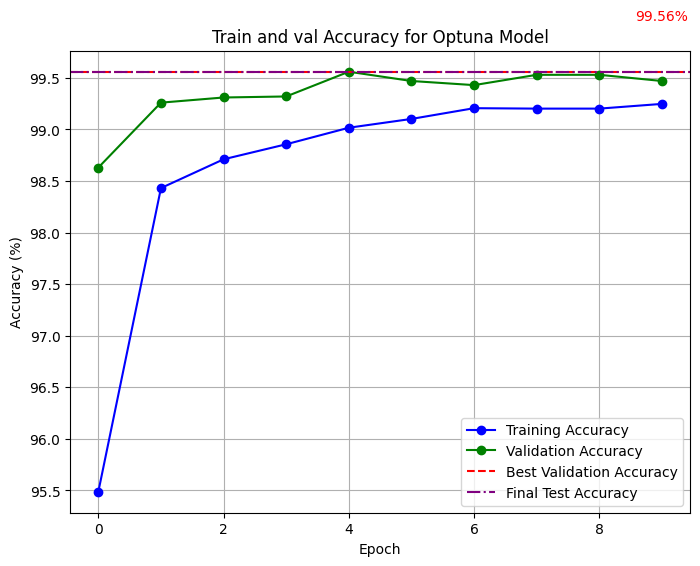

Final Test Accuracy: 99.56%


In [ ]:
final_model.load_state_dict(torch.load('best_model.pth'))
final_model.eval()

test_loss, test_acc = evaluate(final_model, test_loader, criterion)

plt.figure(figsize=(8, 6))
plt.plot(train_acc_history_final, label='Training Accuracy', marker='o', color='blue')
plt.plot(val_acc_history_final, label='Validation Accuracy', marker='o', color='green')
plt.axhline(y=best_acc, color='red', linestyle='--', label='Best Validation Accuracy')
plt.axhline(y=test_acc, color='purple', linestyle='-.', label='Final Test Accuracy')
plt.text(num_epochs - 1, test_acc + 0.5, f"{test_acc:.2f}%", color='red', ha='center')

plt.title('Train and val Accuracy for Optuna Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

print(f"Final Test Accuracy: {test_acc:.2f}%")


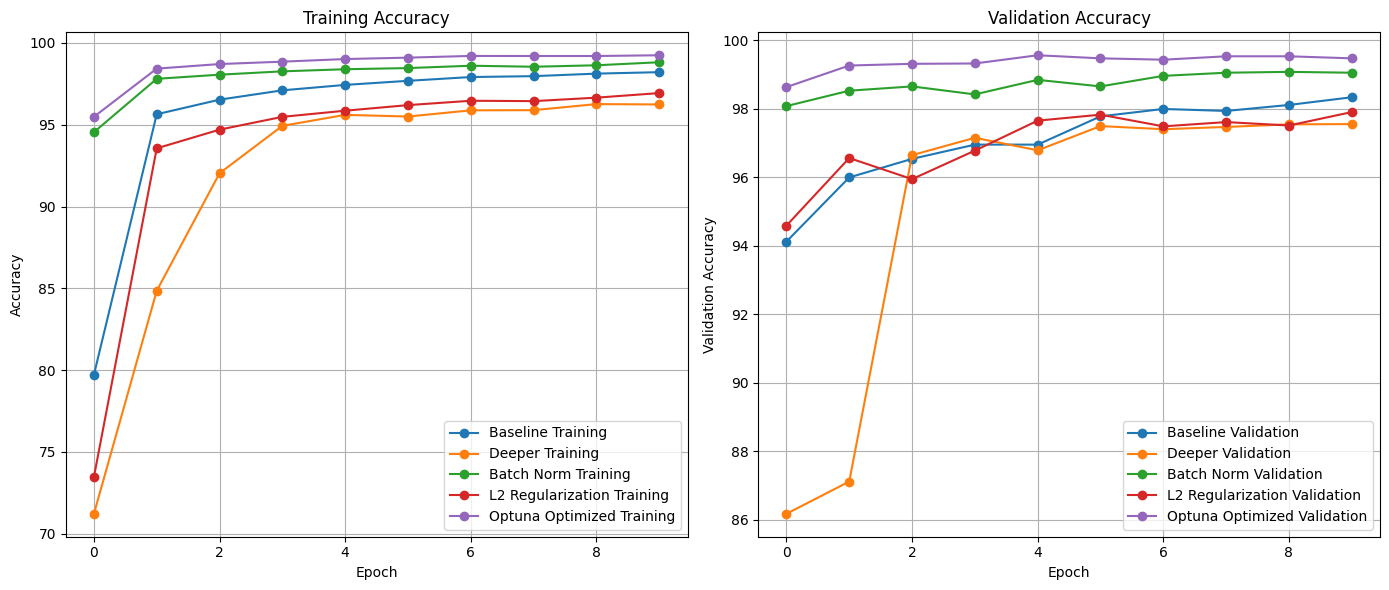

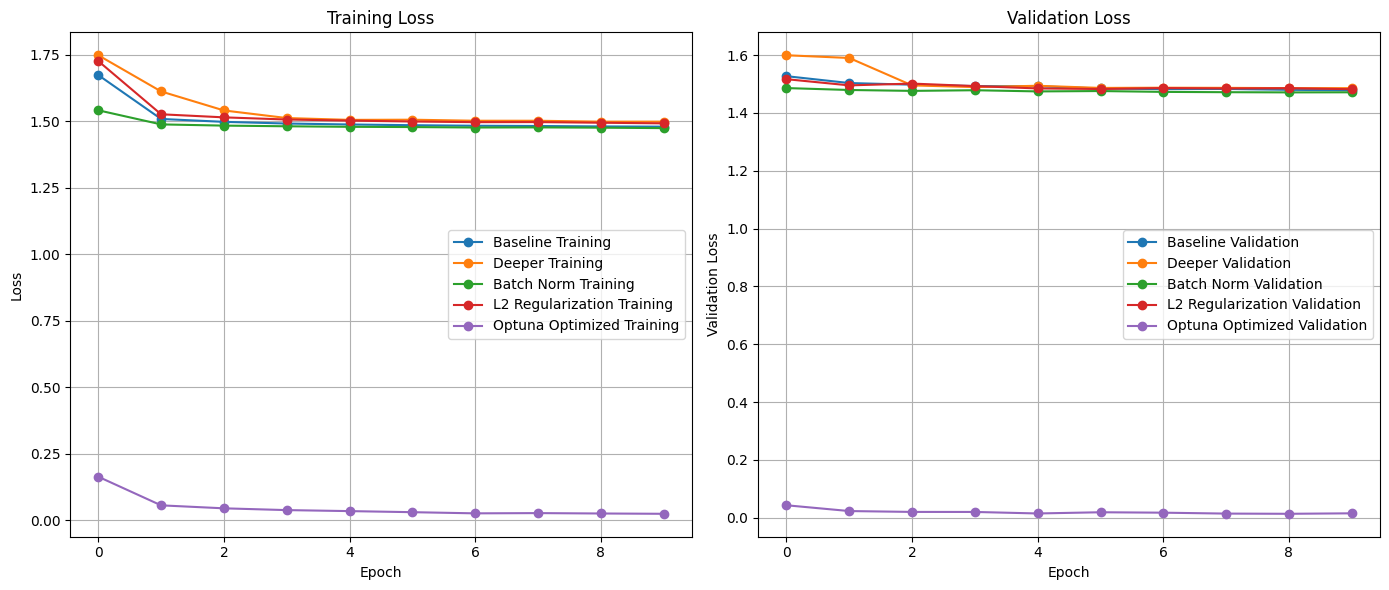

In [ ]:
history_baseline = {
    'train_accuracy': train_acc_history_baseline,
    'val_accuracy': val_acc_history_baseline,
    'train_loss': train_loss_history_baseline,
    'val_loss': val_loss_history_baseline
}

history_deeper = {
    'train_accuracy': train_acc_history_deeper,
    'val_accuracy': val_acc_history_deeper,
    'train_loss': train_loss_history_deeper,
    'val_loss': val_loss_history_deeper
}

history_bn = {
    'train_accuracy': train_acc_history_bn,
    'val_accuracy': val_acc_history_bn,
    'train_loss': train_loss_history_bn,
    'val_loss': val_loss_history_bn
}

history_l2 = {
    'train_accuracy': train_acc_history_l2,
    'val_accuracy': val_acc_history_l2,
    'train_loss': train_loss_history_l2,
    'val_loss': val_loss_history_l2
}

history_final = {
    'train_accuracy': train_acc_history_final,
    'val_accuracy': val_acc_history_final,
    'train_loss': train_loss_history_final,
    'val_loss': val_loss_history_final
}


def plot_training_history(histories, labels, metric='accuracy'):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history[f'train_{metric}'], label=f'{label} Training', marker='o')
    plt.title(f'Training {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history[f'val_{metric}'], label=f'{label} Validation', marker='o')
    plt.title(f'Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Validation {metric.capitalize()}')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

histories = [history_baseline, history_deeper, history_bn, history_l2, history_final]
labels = ['Baseline', 'Deeper', 'Batch Norm', 'L2 Regularization', 'Optuna Optimized']

plot_training_history(histories, labels, metric='accuracy')
plot_training_history(histories, labels, metric='loss')
